<a href="https://colab.research.google.com/github/subhmm/rainGLOBAL/blob/main/GlobalRainfall_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Global Rainfall Rate Prediction

### Importing Modules and Loading Data

In [1]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

In [2]:
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Global = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Global.csv', index_col=[0,1])
Global.head()

1998-01-01  1998-01-02  ...  2019-12-29  2019-12-30
59.875 4.875       21.69        2.55  ...         0.0        0.48
       5.125       17.79        6.75  ...         0.0        0.18
       5.375       10.92        5.88  ...         0.0        0.00
       5.625        6.24        9.60  ...         0.0        0.00
       5.875       14.52       18.66  ...         0.0        0.00

[5 rows x 8031 columns]

######Description of Data

We can get the timeseries of any day by like this

In [5]:
## Find data for lat-lon
Global.loc[(59.875,4.875)]

1998-01-01    21.69
1998-01-02     2.55
1998-01-03     0.00
1998-01-04     2.34
1998-01-05    93.72
              ...  
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.48
Name: (59.875, 4.875), Length: 8031, dtype: float64

#### Automatic Latitude-Longitude Generation

Dataframe is generated automatically if Location name/ co-ordinates are provided. Manual option is also included.

In [6]:
def get_city_coordinates():
  from geopy.geocoders import Nominatim
  geolocator = Nominatim(user_agent="my_user_agent")
  city =input('**HIT ENTER for Manual Mode **OR**\nEnter Location As "City" or "City, Country" format: ')
  country =""
  loc = geolocator.geocode(city+','+ country)
  print("latitude is " ,loc.latitude,"&longtitude is " ,loc.longitude)
  return loc.latitude,loc.longitude

In [7]:
## Findout closest coordinates wrt to available data
def closest(pos):
    latitude = pos[0] 
    longitude = pos[1]
    lat = [59.875 + 0.25*x for x in range(161)]
    lon = [4.875 + 0.25*x for x in range(121)]
    LAT = lat[min(range(len(lat)), key = lambda i: abs(lat[i]-latitude))] 
    LON = lon[min(range(len(lon)), key = lambda i: abs(lon[i]-longitude))] 
    if (abs(latitude-LAT) > 1) or (abs(longitude-LON)>1):
        return 0
    return (LAT,LON)

In [8]:
## Handles error and facilitates manual insersion
def GetLocation():
  try:
    x = closest(get_city_coordinates())
  except AttributeError:
    print("\nEntering Manual Mode")
    def Manual():
      # nonlocal x
      lat = float(input("Enter Latitude: "))
      lon = float(input("Enter Longitude: "))
      y = closest((lat,lon))
      if y==0:
        print('No Data Found, Try Again with other locations\n')
        y = Manual()
      # else:
      #   # print(y)
      return y
    x = Manual()
    # print(x)

  finally:
    if x==0:
        print('No Data Found for this City. Try Again with other Cities.\n')
        df = GetLocation()
    else:
        df = pd.DataFrame(Global.loc[x])
        print(f"Table Created with nearest co-ordinates: {x}")
        df.columns = ['Rainfall']
        display(df)
    return df

**HIT ENTER for Manual Mode **OR**
Enter Location As "City" or "City, Country" format: Stockholm, Switzerland
latitude is  59.3461985 &longtitude is  18.0679891
Table Created with nearest co-ordinates: (59.875, 18.125)


,Rainfall
1998-01-01,0.00
1998-01-02,0.00
1998-01-03,0.00
1998-01-04,0.00
1998-01-05,0.18
...,...
2019-12-26,6.69
2019-12-27,4.98
2019-12-28,21.78
2019-12-29,0.00


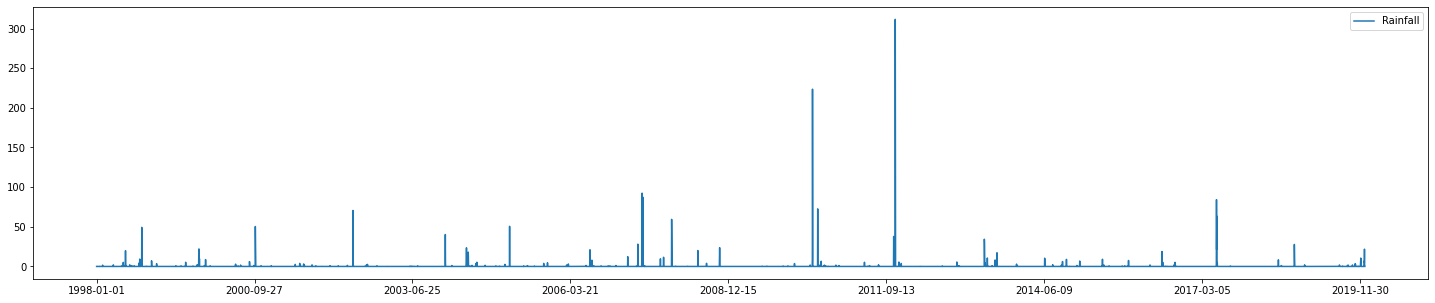

In [9]:
## Run this function to create DataFrame
df = GetLocation()
df.plot(figsize=(25,5))

## MODEL 1: Using FB Prophet

In [10]:
from fbprophet import Prophet

In [11]:
model=Prophet(yearly_seasonality=True, weekly_seasonality=True)

In [12]:
df_fb = df.reset_index()
df_fb.columns = ['ds','y']
df_fb.head()

,ds,y
0,1998-01-01,0.00
1,1998-01-02,0.00
2,1998-01-03,0.00
3,1998-01-04,0.00
4,1998-01-05,0.18


In [13]:
df_fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8031 entries, 0 to 8030
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      8031 non-null   object 
 1   y       8031 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.6+ KB


In [14]:
model.fit(df_fb)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [16]:
future_dates=model.make_future_dataframe(periods=365)

In [17]:
future_dates.tail()

,ds
8391,2020-12-25
8392,2020-12-26
8393,2020-12-27
8394,2020-12-28
8395,2020-12-29


In [18]:
prediction=model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-01-01,0.277002,-7.012988,6.764101,0.277002,0.277002,-0.185114,-0.185114,-0.185114,-0.055200,-0.055200,-0.055200,-0.129914,-0.129914,-0.129914,0.0,0.0,0.0,0.091887
1,1998-01-02,0.276941,-6.741771,7.075978,0.276941,0.276941,-0.225468,-0.225468,-0.225468,-0.060442,-0.060442,-0.060442,-0.165027,-0.165027,-0.165027,0.0,0.0,0.0,0.051473
2,1998-01-03,0.276881,-6.836158,7.311022,0.276881,0.276881,-0.310386,-0.310386,-0.310386,-0.112120,-0.112120,-0.112120,-0.198266,-0.198266,-0.198266,0.0,0.0,0.0,-0.033506
3,1998-01-04,0.276820,-7.204853,6.824062,0.276820,0.276820,-0.296450,-0.296450,-0.296450,-0.067545,-0.067545,-0.067545,-0.228905,-0.228905,-0.228905,0.0,0.0,0.0,-0.019630
4,1998-01-05,0.276760,-6.958475,7.519706,0.276760,0.276760,-0.211354,-0.211354,-0.211354,0.044958,0.044958,0.044958,-0.256312,-0.256312,-0.256312,0.0,0.0,0.0,0.065406


In [19]:
# model.plot(prediction)

Text(0.5, 1.0, 'Prediction for ONE YEAR after 2018')

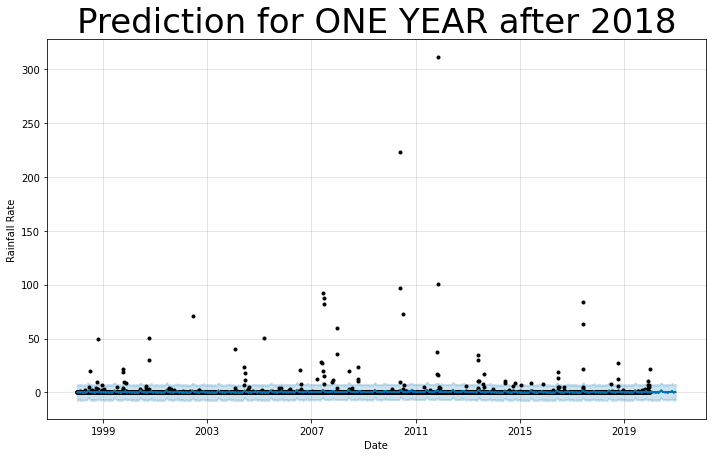

In [20]:
fig = model.plot(prediction, xlabel='Date', ylabel='Rainfall Rate')
ax = fig.gca()
ax.set_title("Prediction for ONE YEAR after 2019", size=34)

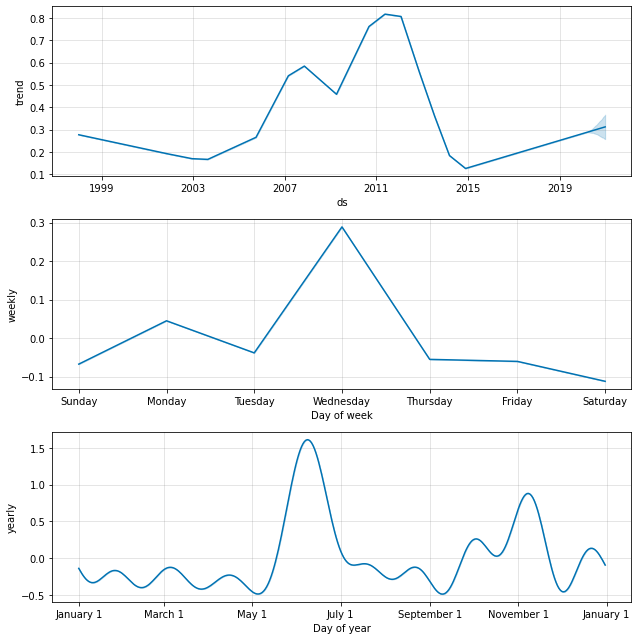

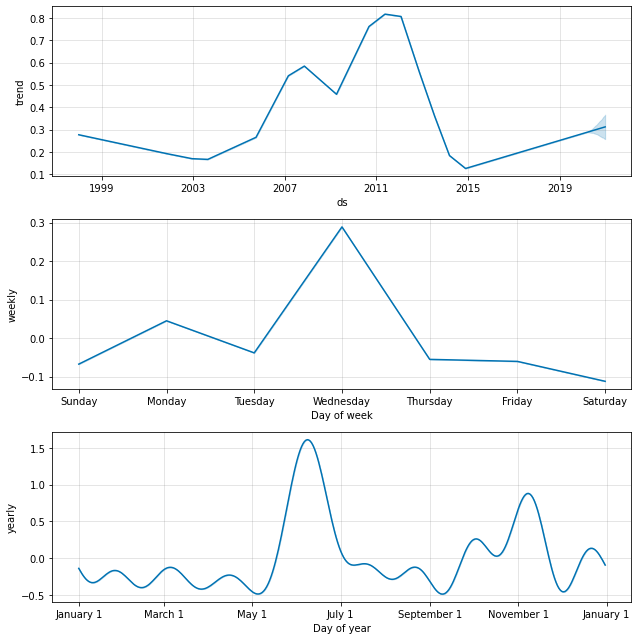

In [21]:
### plot the predicted projection
model.plot_components(prediction)

### Weekly Prediction for another one year

In [22]:
from datetime import datetime
weekly = df_fb
weekly['ds'] = weekly['ds'].astype('datetime64[ns]')
#convert daily data to weekly
weekly_data = weekly.resample('W-Wed', label='right', closed = 'right', on='ds').mean().reset_index().sort_values(by='ds')

In [23]:
weekly_data

,ds,y
0,1998-01-07,0.025714
1,1998-01-14,0.034286
2,1998-01-21,0.030000
3,1998-01-28,0.000000
4,1998-02-04,0.000000
...,...,...
1143,2019-12-04,1.590000
1144,2019-12-11,1.628571
1145,2019-12-18,0.000000
1146,2019-12-25,0.030000


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


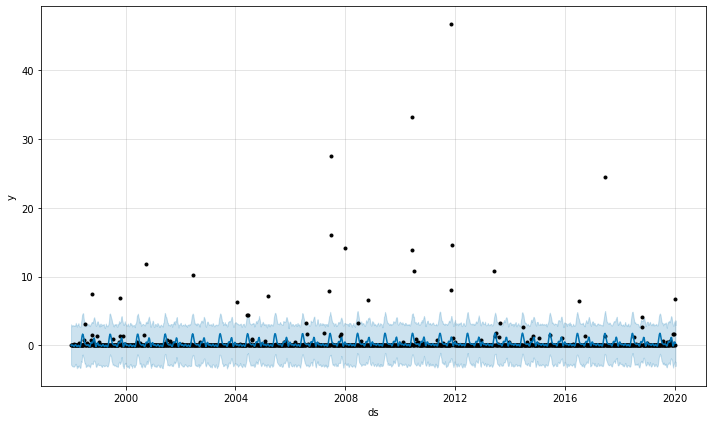

In [24]:
m = Prophet(changepoint_prior_scale=0.01).fit(weekly_data)
future = m.make_future_dataframe(periods=52, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

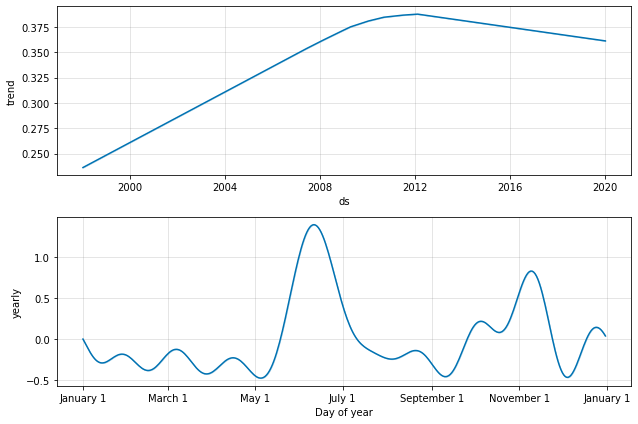

In [25]:
fig = m.plot_components(fcst)

#### Testing Accuracy

In [26]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '400 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-11-25 00:00:00 and 2018-11-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-26,0.054271,-6.540906,7.749295,0.0,2018-11-25
1,2018-11-27,-0.100445,-6.828903,7.699467,0.0,2018-11-25
2,2018-11-28,0.189347,-6.887573,7.920443,0.0,2018-11-25
3,2018-11-29,-0.221743,-7.632771,7.141118,0.0,2018-11-25
4,2018-11-30,-0.252045,-6.868264,7.061415,0.0,2018-11-25


In [27]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,40 days,0.158428,0.398031,0.264010,inf,1.0
1,41 days,0.158778,0.398470,0.265906,inf,1.0
2,42 days,0.158714,0.398389,0.265562,inf,1.0
3,43 days,0.157824,0.397271,0.261238,inf,1.0
4,44 days,0.156794,0.395972,0.257925,inf,1.0


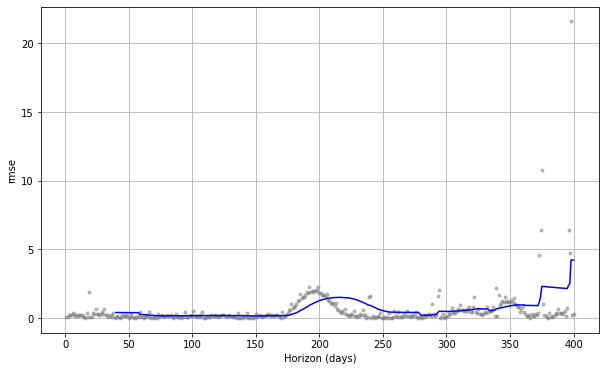

In [28]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## MODEL 2: LSTM

##### Library Import

In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##### Data Loading

In [30]:
training_set = df.copy()

In [31]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

##### Model

In [32]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

##### Training

In [33]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.10221
Epoch: 100, loss: 0.00040
Epoch: 200, loss: 0.00039
Epoch: 300, loss: 0.00039
Epoch: 400, loss: 0.00039
Epoch: 500, loss: 0.00038
Epoch: 600, loss: 0.00038
Epoch: 700, loss: 0.00038
Epoch: 800, loss: 0.00038
Epoch: 900, loss: 0.00038
Epoch: 1000, loss: 0.00038
Epoch: 1100, loss: 0.00038
Epoch: 1200, loss: 0.00038
Epoch: 1300, loss: 0.00038
Epoch: 1400, loss: 0.00038
Epoch: 1500, loss: 0.00038
Epoch: 1600, loss: 0.00038
Epoch: 1700, loss: 0.00038
Epoch: 1800, loss: 0.00038
Epoch: 1900, loss: 0.00038


##### Testing

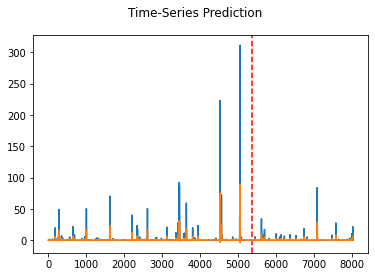

In [34]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Red line showing TEST-TRAIN Split

## Model 3: Arima/Sarimax Monthly Prediction

##### Loading Data

In [41]:
### Creating Monthly Distribution
DF = df.resample('MS').mean()
DF

,Rainfall
1998-01-01,0.020323
1998-02-01,0.058929
1998-03-01,0.000000
1998-04-01,0.066000
1998-05-01,0.004839
...,...
2019-08-01,0.016452
2019-09-01,0.133000
2019-10-01,0.258387
2019-11-01,0.100000


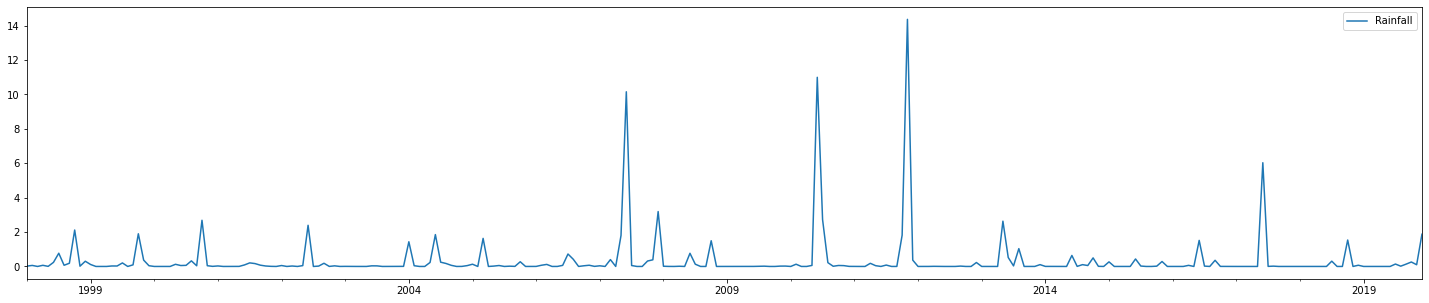

In [44]:
DF.plot(figsize=(25,5))

In [45]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [47]:
test_result=adfuller(DF['Rainfall'])

In [48]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(rainrate):
    result=adfuller(rainrate)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [49]:
adfuller_test(DF['Rainfall'])

ADF Test Statistic : -14.387773896039226
p-value : 8.929683337190833e-27
#Lags Used : 0
Number of Observations Used : 263
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


###### Differencing

In [50]:
DF['Rainrate First Difference'] = DF['Rainfall'] - DF['Rainfall'].shift(1)

In [51]:
DF['Seasonal First Difference']=DF['Rainfall'] - DF['Rainfall'].shift(12)

In [55]:
DF.head(14)

,Rainfall,Rainrate First Difference,Seasonal First Difference
1998-01-01,0.020323,NaN,NaN
1998-02-01,0.058929,0.038606,NaN
1998-03-01,0.000000,-0.058929,NaN
1998-04-01,0.066000,0.066000,NaN
1998-05-01,0.004839,-0.061161,NaN
1998-06-01,0.237000,0.232161,NaN
1998-07-01,0.768387,0.531387,NaN
1998-08-01,0.068710,-0.699677,NaN
1998-09-01,0.186000,0.117290,NaN
1998-10-01,2.117419,1.931419,NaN


In [56]:
## Again test dickey fuller test
adfuller_test(DF['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.9568989438344553
p-value : 0.0016538006496625748
#Lags Used : 16
Number of Observations Used : 235
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


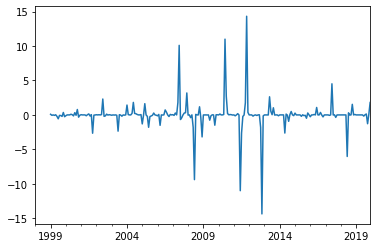

In [57]:
DF['Seasonal First Difference'].plot()

#### Auto Regressive Model

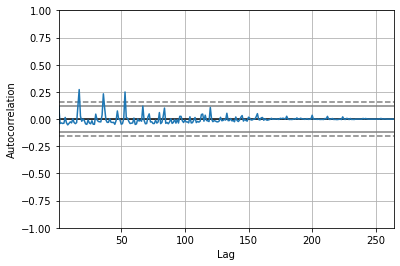

In [61]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(DF['Rainfall'])
plt.show()


#####Autocorrelation and Partial Autocorrelation

    Identification of an AR model is often best done with the PACF.
        For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

    Identification of an MA model is often best done with the ACF rather than the PACF.

        For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

        p,d,q p AR model lags d differencing q MA lags



In [63]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

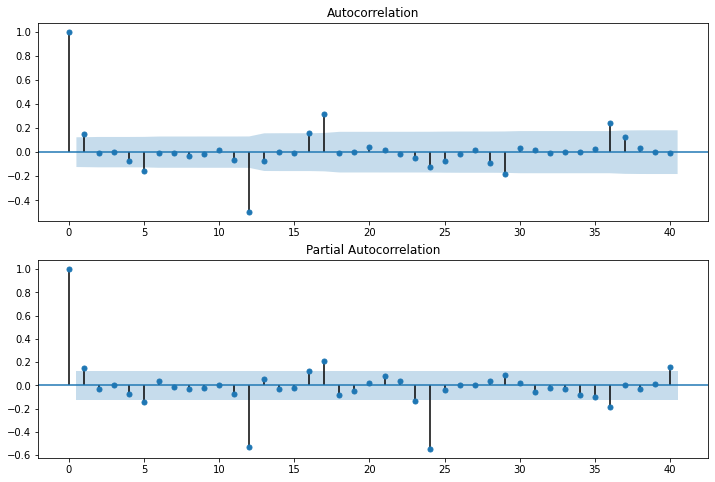

In [65]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(DF['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(DF['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [66]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [67]:
model=ARIMA(DF['Rainfall'],order=(1,1,1))
model_fit=model.fit()

In [68]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Rainfall   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -461.929
Method:                       css-mle   S.D. of innovations              1.387
Date:                Wed, 03 Mar 2021   AIC                            931.858
Time:                        11:50:13   BIC                            946.147
Sample:                    02-01-1998   HQIC                           937.600
                         - 12-01-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0004      0.001      0.292      0.770      -0.002       0.003
ar.L1.D.Rainfall     0.1168      0.061      1.901      0.058      -0.004       0.237
ma.L1.D.Rainfall    -1.0000      0.013    -78.297      0.000      -1.025      -0.975
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            8.5615           +0.0000j            8.5615            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

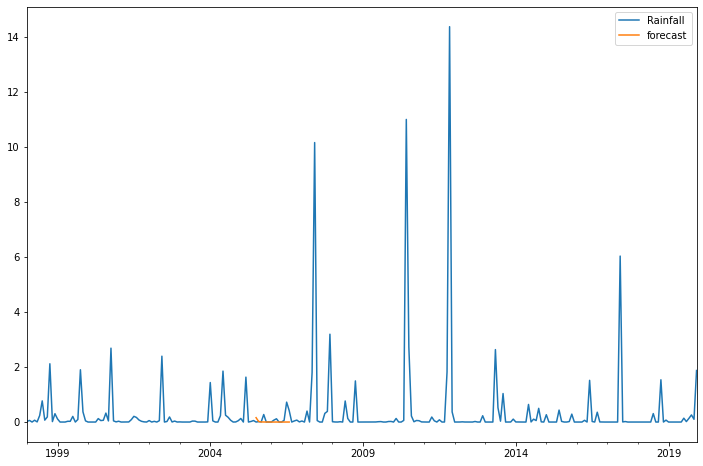

In [69]:
DF['forecast']=model_fit.predict(start=90,end=120,dynamic=True)
DF[['Rainfall','forecast']].plot(figsize=(12,8))

Therefore, ARIMAX is not suitable for seasonal data

#### Sarimax

In [70]:
import statsmodels.api as sm

In [71]:
model=sm.tsa.statespace.SARIMAX(DF['Rainfall'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

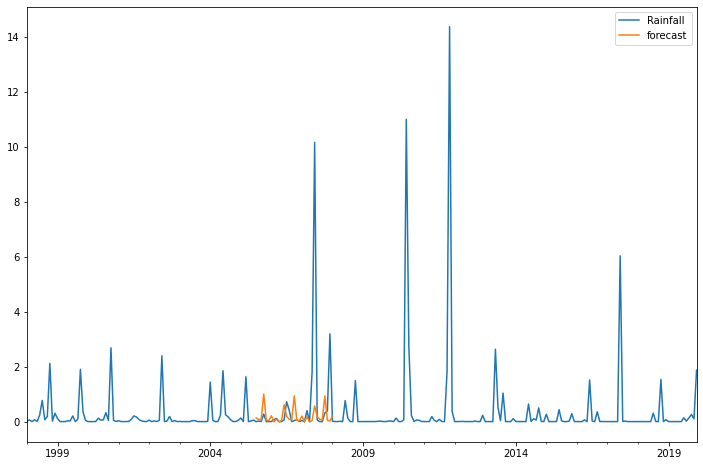

In [74]:
DF['forecast']=results.predict(start=90,end=120,dynamic=True)
DF[['Rainfall','forecast']].plot(figsize=(12,8))

In [76]:
from pandas.tseries.offsets import DateOffset
future_dates=[DF.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [77]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=DF.columns)

In [78]:
future_datest_df.tail()

,Rainfall,Rainrate First Difference,Seasonal First Difference,forecast
2021-07-01,NaN,NaN,NaN,NaN
2021-08-01,NaN,NaN,NaN,NaN
2021-09-01,NaN,NaN,NaN,NaN
2021-10-01,NaN,NaN,NaN,NaN
2021-11-01,NaN,NaN,NaN,NaN


In [83]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 1998-01-01 to 2019-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rainfall                   264 non-null    float64
 1   Rainrate First Difference  263 non-null    float64
 2   Seasonal First Difference  252 non-null    float64
 3   forecast                   31 non-null     float64
dtypes: float64(4)
memory usage: 20.3 KB


In [80]:
future_df=pd.concat([DF,future_datest_df])

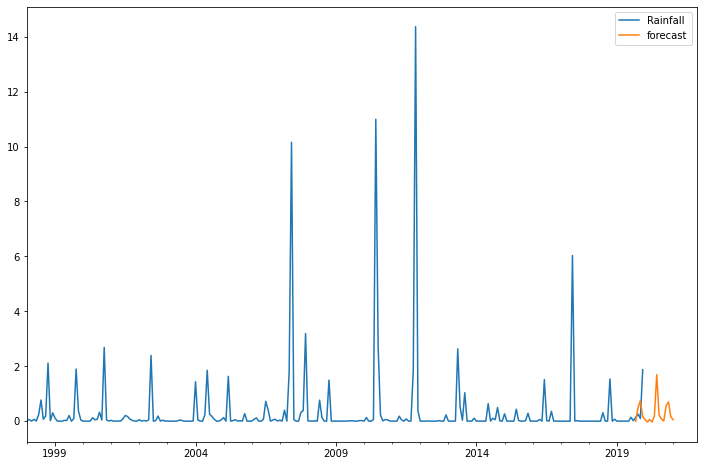

In [85]:
future_df['forecast'] = results.predict(start = 260, end = 276, dynamic= True)  
future_df[['Rainfall', 'forecast']].plot(figsize=(12, 8))

### Thank You